In [2]:
from lab1_proto import *
from lab1_tools import *
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import mixture
from scipy.cluster.hierarchy import dendrogram, linkage

## Load data

In [3]:
data = np.load('lab1_data.npz',allow_pickle=True)['data']
example = np.load('lab1_example.npz',allow_pickle=True)['example'].item()
samples = example['samples']
samplingrate = int(example['samplingrate']/1000)  #sampling per millisecond
winlen = 20*samplingrate
winshift = 10*samplingrate

## 4.1 Enframe

### Q1 Figure out the length and shift in samples from the sampling rate and write it in the lab report.
### （The window length means how many samples you get for each frame; the window shift means after sampling for a frame, the gap between sampling for the next frame. ）

## 4.2 Pre-emphasis

### Q2 Explain how you defined the filter coefficients.
### (According to the equation about high pass FIR filter: y(t)=x(t)-p*x(t-1), and the defination of the lfilter function, the coefficient of y(t) should be a, so a=[1]; the coefficients of x(t) and x(t-1) should be b, therefore b=[1,-p],p=0.97)

## 4.4 Fast Fourier Transform

### Q3 What is f_max in this case accoring to the Sampling Theorem?
### (The FFT bins correspond to frequencies that go from 0 to f_max and back to 0, so f_max should be 0.5*samplingRate) 




## Exract mfcc features

In [5]:
t=7
fig, ax = plt.subplots(nrows=t,ncols=2,figsize=(t+3,t*2))
emph = enframe(samples,winlen,winshift)  
ax[0][0].pcolormesh(emph.T)
ax[0][0].set_title('enframed samples')
ax[0][1].pcolormesh(example['frames'].T)

preemp_emph = preemp(emph)
ax[1][0].pcolormesh(preemp_emph.T)
ax[1][0].set_title('preemphasis')
ax[1][1].pcolormesh(example['preemph'].T)

windows = windowing(preemp_emph)
ax[2][0].pcolormesh(windows.T)
ax[2][0].set_title('hamming window')
ax[2][1].pcolormesh(example['windowed'].T)

pSpec = powerSpectrum(windows,512)
ax[3][0].pcolormesh(pSpec.T)
ax[3][0].set_title('abs(FFT)$^2$')
ax[3][1].pcolormesh(example['spec'].T)

melSpec = logMelSpectrum(pSpec,20000)
ax[4][0].pcolor(melSpec.T)
ax[4][0].set_title('Mel')
ax[4][1].pcolormesh(example['mspec'].T)

cStrum = cepstrum(melSpec,13)
ax[5][0].pcolormesh(cStrum.T)
ax[5][0].set_title('mfcc')
ax[5][1].pcolormesh(example['mfcc'].T)

ax[6][0].pcolormesh(lab1tools.lifter(cStrum).T)
ax[6][0].set_title('lmfcc')
ax[6][1].pcolormesh(example['lmfcc'].T)

fig.tight_layout()
plt.show()

## 4.5 Mel filterbank log spectrum
### Create a bank of triangular filters linearly spaced in Mel frequency scale.

In [ ]:
tbank=trfbank(20000, pSpec.shape[1])
print(tbank.shape)
for i in range(tbank.shape[0]):
    plt.plot(tbank[i])
plt.xlim(0,200)
plt.show()

## 4.6 Cosine Transform and Liftering
### Note that using the n=13 input parameters in dct is not the same as running without the argument and taking the first 13 elements in the results, try to explain why.
### ()

## compute correlations

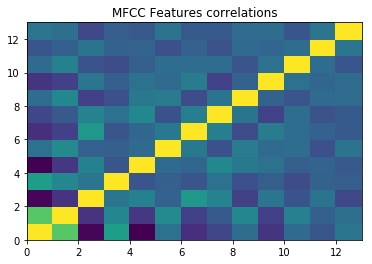

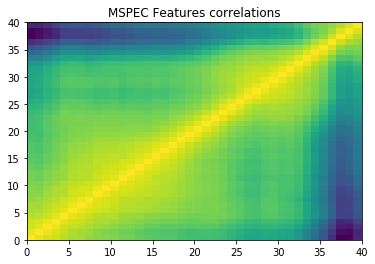

In [4]:
#feature correlation
mfccFeatures = mfcc(data[0]['samples'])
mspecFeatures = mspec(data[0]['samples'])

for i in range(1,len(data)):
    mfccFeatures = np.vstack((mfccFeatures,mfcc(data[i]['samples'])))
    mspecFeatures = np.vstack((mspecFeatures,mspec(data[i]['samples'])))

mfccCorr = np.corrcoef(mfccFeatures.T)
plt.title("MFCC Features correlations")
plt.pcolormesh(mfccCorr)
plt.show()


mspecCorr = np.corrcoef(mspecFeatures.T)
plt.title("MSPEC Features correlations")
plt.pcolormesh(mspecCorr)
plt.show()



## Train GMMs

In [5]:
n_components = [4,8,16,32]
models=[]
for i in n_components:
    model = mixture.GaussianMixture(i,covariance_type='diag')
    model.fit(mfccFeatures)
    models.append(model)

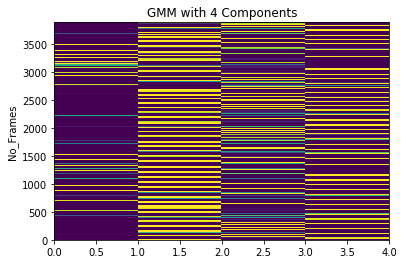

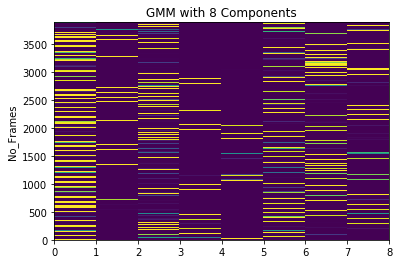

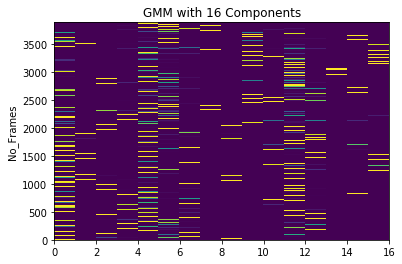

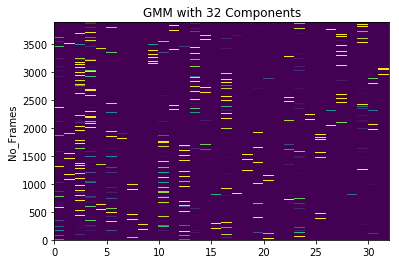

In [6]:
for i in range(4): 
    poster=models[i].predict_proba(mfccFeatures) 
    plt.ylabel('No_Frames') 
    plt.title("GMM with %d Components"%n_components[i]) 
    plt.pcolormesh(poster) 
    plt.show()

### Consider utterances containing the same words and observe the evolution of the GMM posteriors. ()Can you say something about the classes discovered by the unsupervised learning method?() Do the classes roughly correspond to the phonemes you expect to compose each word?()

plot and discuss the GMM posteriors for the model with 32 components for the four occurrences of the word “seven” (utterances 16, 17, 38, and 39).

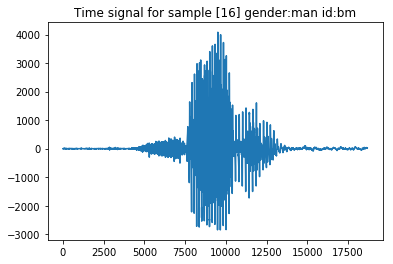

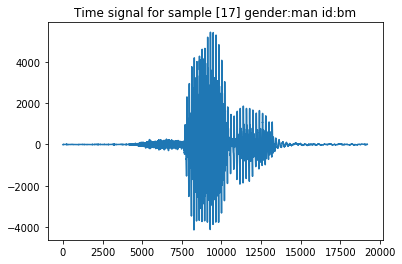

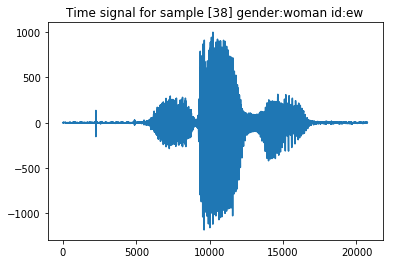

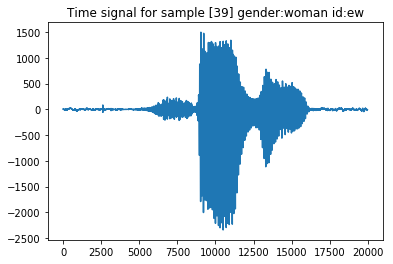

In [7]:
utterances_index = [16, 17, 38, 39]
for i in utterances_index:
    plt.title('Time signal for sample [%d] gender:%s id:%s'%(i,data[i]['gender'],data[i]['speaker']))
    plt.plot(data[i]['samples'])
    plt.show()

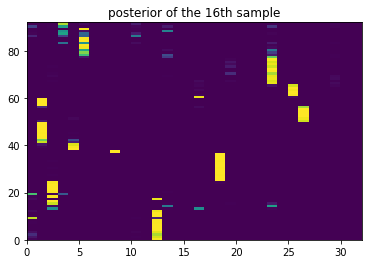

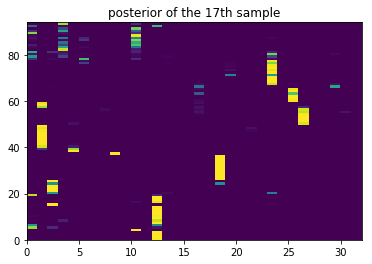

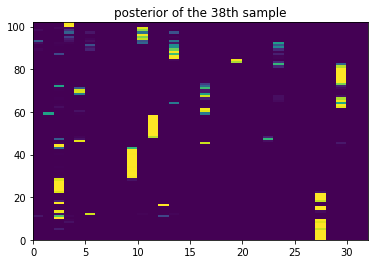

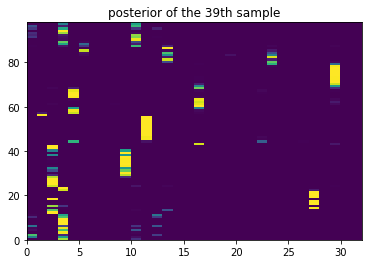

In [8]:

for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster=models[3].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster)
    plt.show()

## global distance

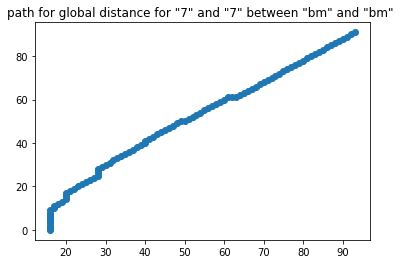

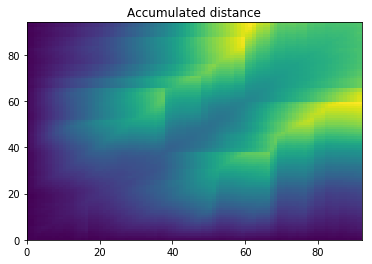

174.37048221271505


In [36]:
def distance(p,q):
    sample1=mfcc(data[p]['samples'])
    sample2=mfcc(data[q]['samples'])
    d,LD,AD,path=dtw(sample1,sample2)
    plt.scatter(path[:,0],path[:,1])
    plt.title('path for global distance for "%s" and "%s" between "%s" and "%s" '%(data[p]['digit'],data[q]['digit'],data[p]['speaker'],data[q]['speaker']))
    plt.show()
    plt.pcolormesh(AD)
    plt.title('Accumulated distance')
    plt.show()
    print(d)
distance(17,16)

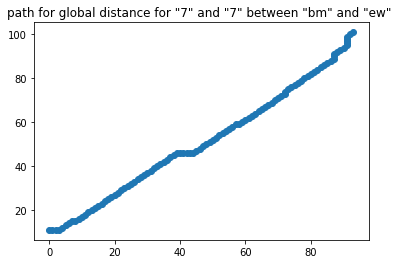

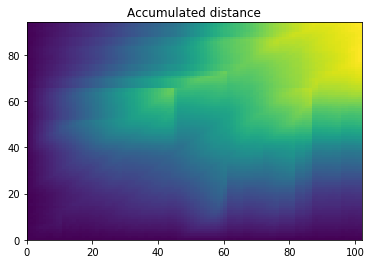

291.05256720220893


In [37]:
distance(17,38)

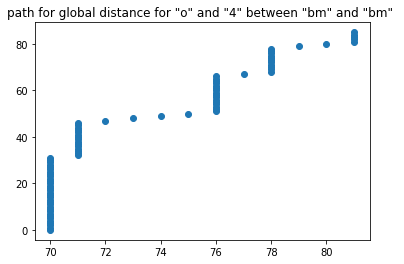

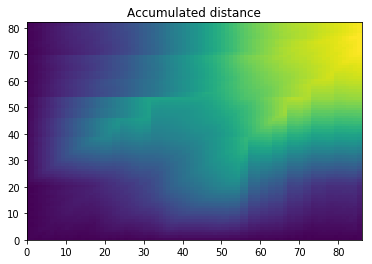

297.15280204490057


In [38]:
distance(0,11)

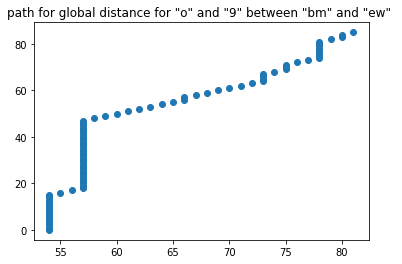

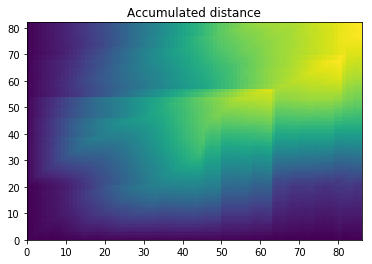

309.1859686975953


In [40]:
distance(0,42)

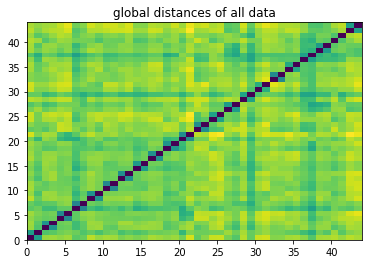

In [30]:
N = len(data)
GD = np.array([dtw(mfcc(data[i]['samples']),mfcc(data[j]['samples']),flag=True) for j in range(N) for i in range(N)]).reshape((N,N))
plt.title('global distances of all data')
plt.pcolormesh(GD)
plt.show()

C:\Users\XC\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


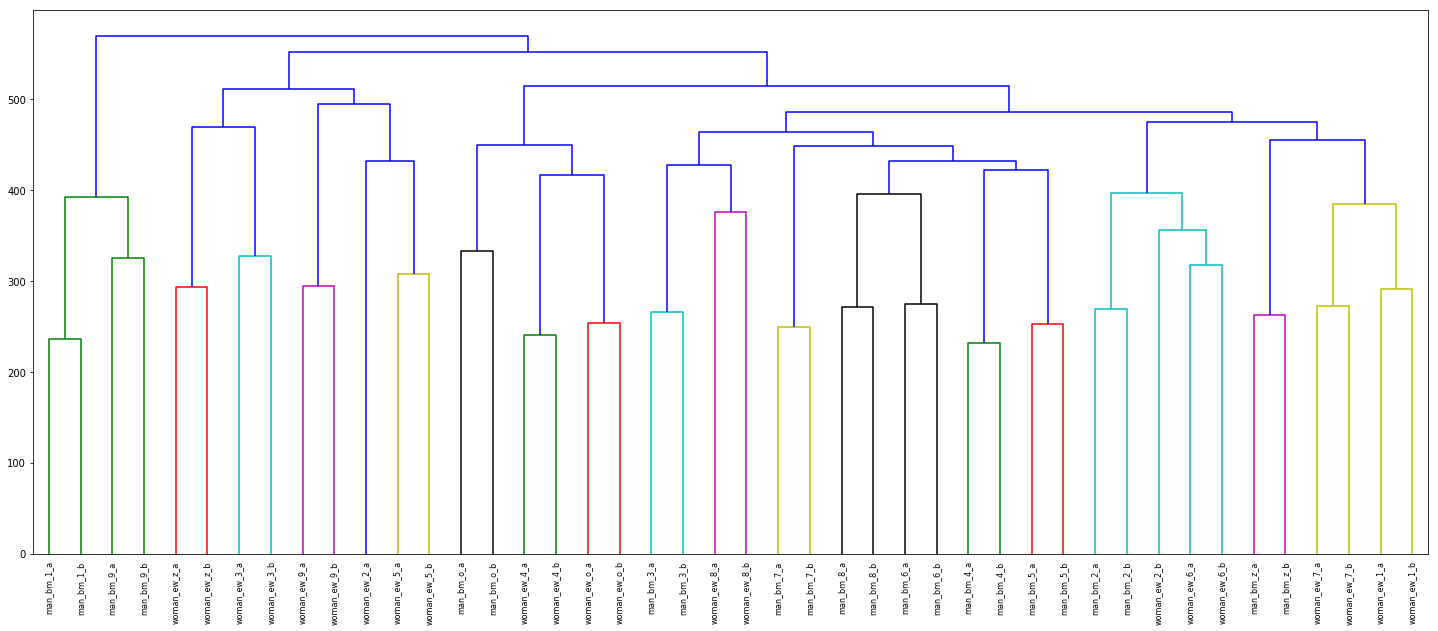

In [41]:
Z=linkage(GD, method='complete')
plt.figure(figsize=(25, 10))
dendrogram(Z,labels=tidigit2labels(data))
plt.show()